# Experiments with sklearn and lightgbm...
### ref on sklearn approach: https://www.kaggle.com/c/avazu-ctr-prediction/discussion/12314
### ref on `category_encoders package`:  http://contrib.scikit-learn.org/categorical-encoding/index.html
### Yannick Martel team: https://medium.com/@chris_bour/our-avazu-kaggle-challenge-logbook-b522ccb1ed21
### Yannick Martel Part 1 (intro): https://www.quantmetry.com/single-post/2015/03/12/My-first-Kaggle-challenge-the-Avazu-CTR-contest
### Yannick Martel Part 2 (feature engineering): https://www.quantmetry.com/single-post/2016/10/18/My-first-Kaggle-challenge-the-Avazu-CTR-contest---Part-2

### Shuffle the training data, in the ``bash`` shell: 
### -- strip the header: ``tail -40429867 train.csv > train.csv``
### -- shuffle the rows, in place: ``shuf -o train.csv < train.csv``

## Build the model, tune the hyperparameters by cross-validation, archive the model

start with 22 features
Index(['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')
adding engineered datetime features...
dropping Index([], dtype='object')
mapping dataframe to str...
Encoding features numerically...
Start training...
Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.414634	valid_1's binary_logloss: 0.419093
[20]	training's binary_logloss: 0.400716	valid_1's binary_logloss: 0.41091
[30]	training's binary_logloss: 0.391963	valid_1's binary_logloss: 0.408855
[40]	training's binary_logloss: 0.385036	valid_1's binary_logloss: 0.408376
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.389038	valid_1's binary_logloss: 0.408337
elapsed time: 0:00:13.225756 
Plot logloss recorded d

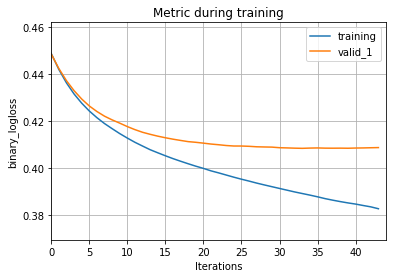

Plot feature importances...


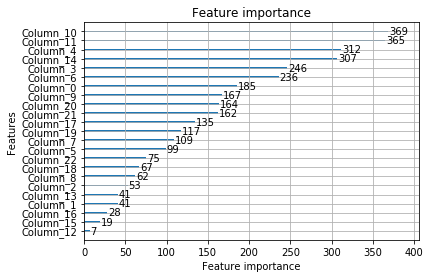

archiving model...


In [2]:
"""
======================================================
Out-of-core classification of  Avazu data
======================================================
wc count for train.csv 40428968
wc count for test.csv   4577465

Feature engineering
Feature hashing
SGD classifier with partial fit
"""

# Authors: Elena Cuoco <elena.cuoco@gmail.com>

# Avazu competitition using pandas and sklearn library
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import category_encoders as ce
import pickle
import gc
import copy
#import xlearn as xl
%matplotlib inline
from datetime import datetime, date, time
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.feature_extraction import FeatureHasher
from sklearn import preprocessing 
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier #note: activate the xgboost environment
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

###################################################################################
# create the feature matrix and the target labels vector
def transform_categorical_features(data,categorical_method,drop_column,important_columns):

    # get target labels vector
    y_train = data['click'].values
    y_train = np.asarray(y_train).ravel()
        
    # remove id and click columns from the dataframe
    data = data.drop(['id','click'], axis=1)
    print('start with ' +str(data.shape[1])+' features')
    print(data.columns)
    
    # add engineered features related to datetime
    add_engineered_datetime_features = True
    if(add_engineered_datetime_features): 
        print('adding engineered datetime features...')
        data['hour']=data['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))
        data['dayoftheweek']=data['hour'].map(lambda x:  x.weekday())
        # removing day, since it cannot be predictive, as the test data has a different day
        # data['day']=data['hour'].map(lambda x:  x.day)
        data['hour']=data['hour'].map(lambda x:  x.hour)
        
    # drop selected columns
    print('dropping '+str(data.columns[drop_column]))
    data = data.drop(data.columns[drop_column], axis=1) 
        
    # map data columns to str objects
    print('mapping dataframe to str...')
    data= data.applymap(str)
    
        
    # option to add bilinear features
    add_bilinear_features = False
    if(add_bilinear_features):
        
        # initialize timer
        start_time = datetime.now()
        print('adding bilinear features...')
        columns = data.columns.tolist()
        count = 0
        bilinear_features = []
        for col_1 in columns:
            for col_2 in columns:
                col_12 = "_".join([col_1,col_2])
                col_21 = "_".join([col_2,col_1])
                bilinear_features.append(col_21)
                # filter out duplicates (order of col_1 and col_2 doesn't matter,
                #     and col_12 when col1 == col2 is not a new feature)
                if col_1 != col_2 and col_12 not in bilinear_features:
                    count+=1
                    data[col_12] = data[[col_1,col_2]].apply(lambda x: "".join(x),axis=1)
                    print('bilinear feature #',count,col_1,col_2,col_12)        
                    print('\nelapsed time ',datetime.now()-start_time)

        # Elapsed time for creating bilinear features
        print('time to create biliinear features ',datetime.now()-start_time)
        
         
        
        # check
        print('There are ' +str(data.shape[1])+' features')
        print(data.describe())
        print(data.info())

        # option to pickle the data frame with bilinear features added
        pickle_bilinear = True
        if(pickle_bilinear):
            data.to_pickle('data_bilinear.pkl', compression='infer', protocol=-1)
    
    
    # Record the feature names
    features = data.columns
        
    # hash or encode the features
    if(categorical_method == 'hash'):
        
        # features matrix
        X_train = np.asarray(data)
    
        # hash all features, create features matrix
        print('Hashing features...')        
        X_train = preproc.fit_transform(X_train)

        
    elif(categorical_method == 'encode'):
        
        # encode all features
        print('Encoding features numerically...')
        encoder = preprocessing.LabelEncoder()
        data = data.apply(encoder.fit_transform)
        
        # one-hot encode -- fails due to memory error
        # encoder = preprocessing.OneHotEncoder()
        # encoder.fit(data)
        # data = encoder.transform(data).toarray()
               
        # binarize features -- doesn't help, makes logloss worse
        binarize_features = False
        if(binarize_features):
            print('Binarizing features...')
            encoder = ce.BinaryEncoder(cols=data.columns.tolist()).fit(data)
            data = encoder.transform(data)
        
        # features matrix
        X_train = np.asarray(data) 
        
        
    return y_train, X_train, features, data


###############################################################################

#def main():
#if __name__ == '__main__':
    
# set control parameters

important_columns = []

# set the number of hash bins
# 2**27 gets same result as 2**29, 2**30 produces memory error
n_features = 2**20

# method of handling categoricals: 'encode' or 'hash'
# categorical_method='encode'
categorical_method='encode'

# chunk_size
chunk_size= 1e5

# feature columns to drop
drop_columns = [[]]
drop_column = drop_columns[0]

# file and folder paths
train_file = 'train_shuffled.csv'
model_path = './'

# number of training examples
n_rows = chunk_size

# seed for random generator
seed = 99

# option to archive model
archive_model = True

# set start time
start = datetime.now()

# column names in original data file
header = ['id','click','hour','C1','banner_pos','site_id','site_domain','site_category','app_id','app_domain','app_category','device_id',\
        'device_ip','device_model','device_type','device_conn_type','C14','C15','C16','C17','C18','C19','C20','C21']

# list of regularization hyperparameter values
# C_range = [1]

# select classifier
classifier = 'lgb'

# Option to tune the hyperparameters by cross-validation
cv_tune = False


#scale_pos_weight = sum(y_train==0)/sum(y_train==1)
scale_pos_weight = 1

# set model parameters
params = {}
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
# params['num_iterations'] = 100 # default
params['feature_fraction'] = 1.#0.05
params['bagging_fraction'] = 1.#0.05
params['bagging_freq'] = 1#10
params['num_threads'] = 4 # number of CPUs
params['is_unbalance'] = False
params['max_bin'] = n_features
params['importance_type'] = 'gain' 
#params['feature_name'] = 'auto' 
#params['categorical_feature'] = 'auto'
# params['n_estimators'] = 500
params['is_unbalance'] = False
params['scale_pos_weight'] = 1
params['min_data_in_leaf'] = 30
params['max_depth'] = -1 
params['learning_rate'] = 0.1#0.03
params['min_data_per_group'] = 5
params['num_leaves'] = 100 # <= 2**max_depth
params['regression_l2'] = 0.

# correction for unbalanced data only makes things worse!
# neg to pos class ratio

# fraction of training data to use 
train_frac = 0.8

# build a preprocessing pipeline for feature hashing
preproc = Pipeline([('fh',FeatureHasher( n_features=n_features,input_type='string'))])
# , \alternate_sign = True, non_negative=False))])


###################################################################################
# build and train model

# load data, specifying features to drop
# for drop_column in drop_columns:


# read data and preprocess
data = pd.read_table(train_file, sep=',', chunksize=chunk_size, names=header,header=None,\
       nrows = n_rows).get_chunk()
# data = pd.read_table(train_file, sep=',', chunksize=chunk_size, names=None,header=0,\

# Select features for which test set has no examples with unseen categories
#     in the dev set
#current_features = ['id','click','hour', 'C1', 'banner_pos','site_category', \
#                    'site_id',
#                    'device_type', 'device_conn_type','C15', 'C16','C18',\
#                    'C19','C21']#, 'dayoftheweek']

current_features = data.columns.tolist()
# Select features for which test set has no examples with unseen categories in the dev set
#current_features = ['click','hour', 'C1', 'banner_pos', 'site_category', 'device_type', \
#                    'device_conn_type', 'C15', 'C16', 'C18', 'C19', 'C21', 'dayoftheweek']
# column names in original data file
#header = ['id','click','hour','C1','banner_pos','site_id','site_domain','site_category',\
#         'app_id','app_domain','app_category','device_id',\
#        'device_ip','device_model','device_type','device_conn_type',\
#        'C14','C15','C16','C17','C18','C19','C20','C21']
data=data[current_features]

# preprocess raw data and format training set for modeling
#    features matrix and target labels vector
y_train, X_train, features, data = transform_categorical_features(data,\
    categorical_method=categorical_method,drop_column=drop_column,\
    important_columns=important_columns)

# dev set consists of first train_frac of training set
y_dev = y_train[:int(train_frac*n_rows)]
X_dev = X_train[:int(train_frac*n_rows),:]

# test set for model evaluation: remaining (1-train_frac) of training set
y_test = y_train[int(train_frac*n_rows):]
X_test = X_train[int(train_frac*n_rows):,:]


# build model,
# optionally tune hyperparameters via cross-validation,
# predict on held-out portion of training set
if cv_tune:
    
    # Using LGBClassifier
    print('tuning hyper-parameters...\n\n')

    # parameter grid to use with cross-validation
    param_grid = {}
    param_grid['min_data_in_leaf'] = [30]
    param_grid['max_depth'] = [20] 
    param_grid['learning_rate'] = [0.1] 
    param_grid['min_data_per_group'] = [30]#[1, 10]
    param_grid['num_leaves'] = [30] # <= 2**max_depth
    param_grid['regression_l2'] = [0]
    param_grid['scale_pos_weight'] = [1]
       
    # override grid with best model
    #param_grid = {'learning_rate': [0.03], 'max_depth': [20], 'min_data_in_leaf': [100],\
    #              'min_data_per_group': [1], 'num_leaves': [30], 'regression_l2': [0.1]}
    
    #param_grid = {'learning_rate': [0.1], 'max_depth': [10], 'min_data_in_leaf': [30],\
    # 'min_data_per_group': [1], 'num_leaves': [30], 'regression_l2': [0.0]}
    
    # build model
    model = LGBMClassifier(**params)

    # tune hyperparameters with cross-validation
    start_time = datetime.now()
    clf = GridSearchCV(model, param_grid=param_grid, cv=5,
                       scoring='neg_log_loss')
    clf.fit(X_dev, y_dev)
    print('time for CV: ',datetime.now()-start_time)

    print('Best parameters set found on development set\n')
    print(clf.best_params_)
    print('\nGrid scores on development set:\n')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print('\nDetailed classification report:\n')
    print('The model is trained on the full development set ',100*train_frac,' % of the training samples')
    print('The scores are computed on the full evaluation set ',100*(1-train_frac),' % of the training samples\n')
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))


    # predict targets for test set and compute log_loss metric
    y_prob = clf.best_estimator_.predict_proba(X_test)
    logloss_test = log_loss(y_test, y_prob)
    print('logloss on test data set: ',logloss_test)

    # create a model object for archiving
    model_object = clf.best_estimator_


else:
    
    # Evaluate on the dev set, validate on the test set
    # using lgb.Dataset

    # create dataset for lightgbm
    lgb_dev = lgb.Dataset(X_dev, y_dev)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_dev)

    # reduce memory footprint
    raw_data=None
    gc.collect()

    # results dict for plotting
    evals_result = {}  

    # add parameters
    #params['min_data_in_leaf'] = 30
    #params['max_depth'] = -1 
    #params['learning_rate'] = 0.03
    #params['min_data_per_group'] = 5
    #params['num_leaves'] = 100 # <= 2**max_depth
    #params['regression_l2'] = 0.

    # train the model
    print('Start training...')
    clf = lgb.train(params,
                    lgb_dev,
                    num_boost_round=300, # same as n_estimators
                    valid_sets=[lgb_dev, lgb_test],
                    categorical_feature='auto',
                    evals_result=evals_result,
                    verbose_eval=10,
                    early_stopping_rounds=10)

    # Check elapsed time
    print('elapsed time: %s ' % (str(datetime.now() - start)))

    # model object for archiving
    model_object = clf

    # plot results

    # logloss
    print('Plot logloss recorded during training...')
    ax = lgb.plot_metric(evals_result, metric='binary_logloss')
    plt.show()

    # importances
    if(categorical_method == 'encode'):
        print('Plot feature importances...')
        ax = lgb.plot_importance(clf, max_num_features=100)
        plt.show()
        
        

# archive the model file from training
# !!!!! caution: model_file may be ~ GBs
archive_model = True
if(archive_model):
    print('archiving model...')
    model_file = model_path+'model-avazu-sgd.pkl'
    joblib.dump(model_object, model_file)

    # archive the preprocessing file from training
    preproc_file=model_path+'model-avazu-preproc.pkl'
    joblib.dump(preproc, preproc_file)






0
23


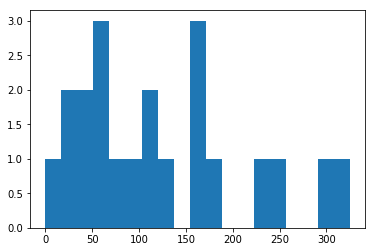

In [3]:
# Identify most important features
#importances = clf.best_estimator_.feature_importances_
#print(importances)
if(categorical_method != 'hash'):
    importances = np.asarray(clf.feature_importance().tolist())

    plt.hist(importances,np.linspace(0,325,20))
    print(sum(importances==0))
    num_imp_cols = sum(importances>5)
    print(num_imp_cols)
    column_inds = np.argsort(importances)[::-1][:num_imp_cols]
    #print(column_inds)
    #important_columns = data.columns[column_inds].tolist()
    #print(important_columns)
    #data = data[important_columns]


## Feature importances from lightgbm,
## with `importance_type = 'gain'`

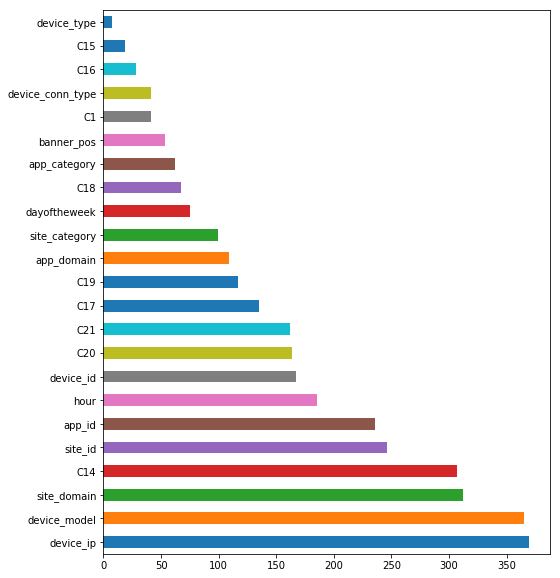

In [4]:
if(categorical_method != 'hash'):
    # importance_type = 'gain'
    importances = np.asarray(clf.feature_importance().tolist())
    feat_imp = pd.Series(importances,index=features)
    feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

## Better feature importances from SHAP (?)
### "it is beneficial to use SHAP package in python to produce stable feature-importance evaluation"
### `https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm?scriptVersionId=4623906`

In [5]:
if(categorical_method != 'hash'):
    import shap
    shap.initjs()

In [6]:
if(categorical_method != 'hash'):
    start_time = datetime.now()
    shap_values = shap.TreeExplainer(clf).shap_values(data)
    print('',datetime.now()-start_time)

 0:01:07.757875


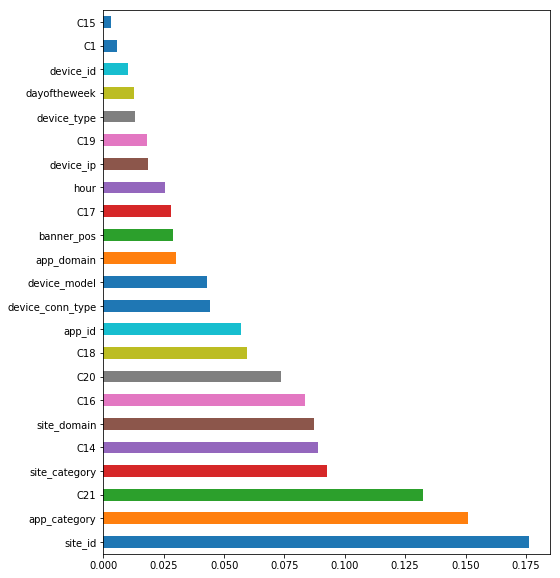

In [7]:
if(categorical_method != 'hash'):
    # normalized sum of abs of importances for each data point in training set
    shap_mean = np.sum(abs(shap_values), axis=0)/shap_values.shape[0]
    shap_mean = pd.Series(shap_mean,index=features)
    np.abs(shap_mean).nlargest(30).plot(kind='barh', figsize=(8,10))

    # median over training set of abs(importance) for each feature
    # -- preserves same ordering as normalized sum of abs importances
    # shap_median = np.median(abs(shap_values), axis=0)
    # shap_median = pd.Series(shap_median,index=features)
    # np.abs(shap_mean).nlargest(30).plot(kind='barh', figsize=(8,10))

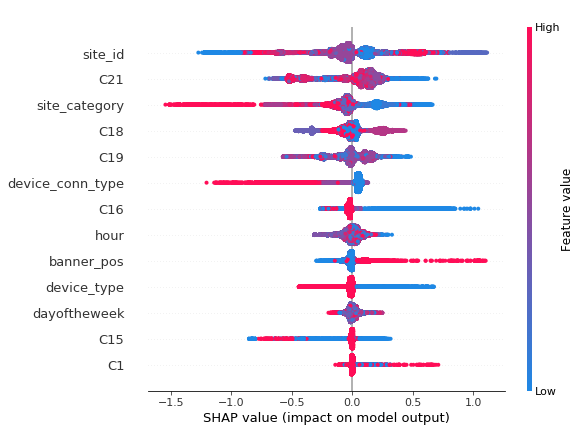

In [34]:
if(categorical_method != 'hash'):
    shap.summary_plot(shap_values, data)
